In [1]:
%load_ext autoreload
%autoreload 2

Libraries

In [22]:
import os
import pandas as pd
import numpy as np
from verbio import readers, preprocessing, temporal, features, settings, visualize
import seaborn as sns
import matplotlib.pyplot as plt

Constants

In [40]:
SUBJECT_LABELS = [f'P{p:03d}' for p in range(1, 74, 1)] # Participants 001-073
TRAIN_SESSIONS = ['TEST01','TEST02','TEST03','TEST04']
TEST_SESSIONS = ['TEST05','TEST06','TEST07','TEST08']
DATA_DIR = '/home/jason/hubbs/project_verbio/data/raw/'
EDA_FILENAME = 'E4_EDA_PPT.xlsx'
HR_FILENAME = 'E4_HR_PPT.xlsx'
ANNOTATION_FILENAME = 'MANUAL_ANNOTATION_PPT.xlsx'
WIN_LEN = 30
WIN_STRIDE = 15
ANNOTATION_THRESHOLD = 3.5

Helper functions

In [41]:
def get_data(participant, session):
    eda_filepath = os.path.join(DATA_DIR, participant, session, EDA_FILENAME)
    hr_filepath = os.path.join(DATA_DIR, participant, session, HR_FILENAME)
    annotation_filepath = os.path.join(DATA_DIR, participant, session, ANNOTATION_FILENAME)
    
    if any(not os.path.exists(x) for x in (eda_filepath, hr_filepath, annotation_filepath)): return None
    
    eda_df = readers.read_excel(eda_filepath)
    hr_df = readers.read_excel(hr_filepath)
    annotation_df = readers.read_excel(annotation_filepath)
    
    eda_fx = get_eda_fx(eda_df)
    hr_fx = get_hr_fx(hr_df)
    annotation_fx = get_annotation_fx(annotation_df)

    min_len = min(len(annotation_fx), len(eda_fx), len(hr_fx))
    annotation_fx = annotation_fx[:min_len]
    eda_fx = eda_fx.iloc[:min_len]
    hr_fx = hr_fx[:min_len]
    
    combined_df = eda_fx
    combined_df['HR'] = hr_fx
    combined_df['Annotation'] = annotation_fx
    
    return combined_df
    
def get_eda_fx(eda_df):
    # Convert EDA signals to numpy
    eda_signal = eda_df['EDA'].to_numpy()
    eda_times = eda_df[settings.time_key].to_numpy()
    # Get EDA features
    eda_fx = features.eda_features(
        signal=eda_signal, 
        times=eda_times, 
        sr=settings.e4_eda_sr, 
        win_len=WIN_LEN, 
        win_stride=WIN_STRIDE
    )[['SCR_Peaks', 'SCR_Amplitude', 'SCL']]
    return eda_fx

def get_hr_fx(hr_df):
    # Convert HR signals to numpy
    hr_signal = hr_df['HR'].to_numpy()
    hr_times = hr_df[settings.time_key].to_numpy()
    # Window HR
    hr_fx = preprocessing.window_timed(
        x=hr_signal,
        times=hr_times,
        win_len=WIN_LEN,
        win_stride=WIN_STRIDE,
        win_fn=lambda x: np.mean(x)
    )
    return np.array(hr_fx)

def get_annotation_fx(annotation_df):
    # Convert annotation signals to numpy
    annotation_r1 = annotation_df['R1'].to_numpy()
    annotation_r2 = annotation_df['R2'].to_numpy()
    annotation_r4 = annotation_df['R4'].to_numpy()
    annotation_r5 = annotation_df['R5'].to_numpy()
    annotation_times = annotation_df[settings.time_key].to_numpy()
    # Combine both annotators
    annotation_mixed = np.vstack([annotation_r1, annotation_r2, annotation_r4, annotation_r5])
    annotation_mean = np.mean(annotation_mixed, axis=0)
    # Window annotations
    annotation_fx = preprocessing.window_timed(
        x=annotation_mean,
        times=annotation_times,
        win_len=WIN_LEN,
        win_stride=WIN_STRIDE,
        win_fn=lambda x: preprocessing.binarize(np.mean(x), threshold=ANNOTATION_THRESHOLD)
    )
    annotation_fx = np.array(annotation_fx, dtype='int')    
    # Shift annotations back in time
    assert WIN_LEN % WIN_STRIDE < 0.1 # Assert that they're at least somewhat divisible
    shift_len = -int(WIN_LEN//WIN_STRIDE)
    return temporal.shift(annotation_fx, shift_len)[:shift_len] # Shift back in time and truncate

Grab raw data from VerBIO dataset for training and testing sessions

In [42]:
train_dict = {}
test_dict = {}

for p in SUBJECT_LABELS:
    valid = True
    participant_train = []
    participant_test = []

    for s in TRAIN_SESSIONS:
        session_data = get_data(p, s)
        if session_data is None:
            valid = False
            break
        else:
            participant_train.append(session_data)
    
    for s in TEST_SESSIONS:
        session_data = get_data(p, s)
        if session_data is None:
            valid = False
            break
        else:
            participant_test.append(session_data)
            
    if valid:
        print(f'Valid participant {p}')
        train_dict[p] = participant_train
        test_dict[p] = participant_test

Valid participant P004
Valid participant P005
Valid participant P008
Valid participant P016
Valid participant P020
Valid participant P021
Valid participant P023
Valid participant P032
Valid participant P035
Valid participant P037
Valid participant P039
Valid participant P041
Valid participant P042
Valid participant P044
Valid participant P047
Valid participant P050
Valid participant P051
Valid participant P053
Valid participant P060
Valid participant P061
Valid participant P062
Valid participant P065
Valid participant P071
Valid participant P073


Run experiment loop

(1116, 5)
(78, 5)
(72, 5)
===All combined===


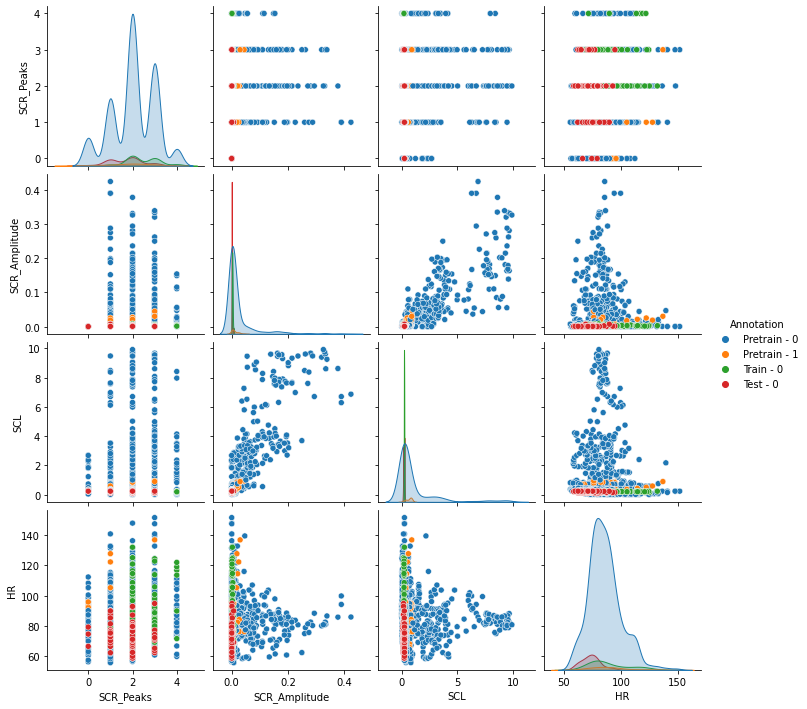

===Only participant===


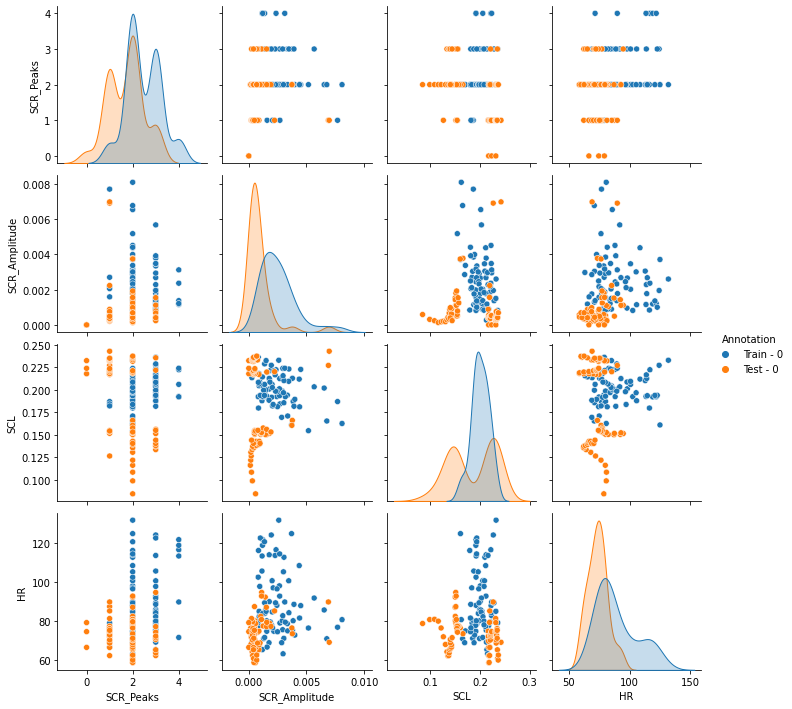

(1157, 5)
(37, 5)
(40, 5)
===All combined===


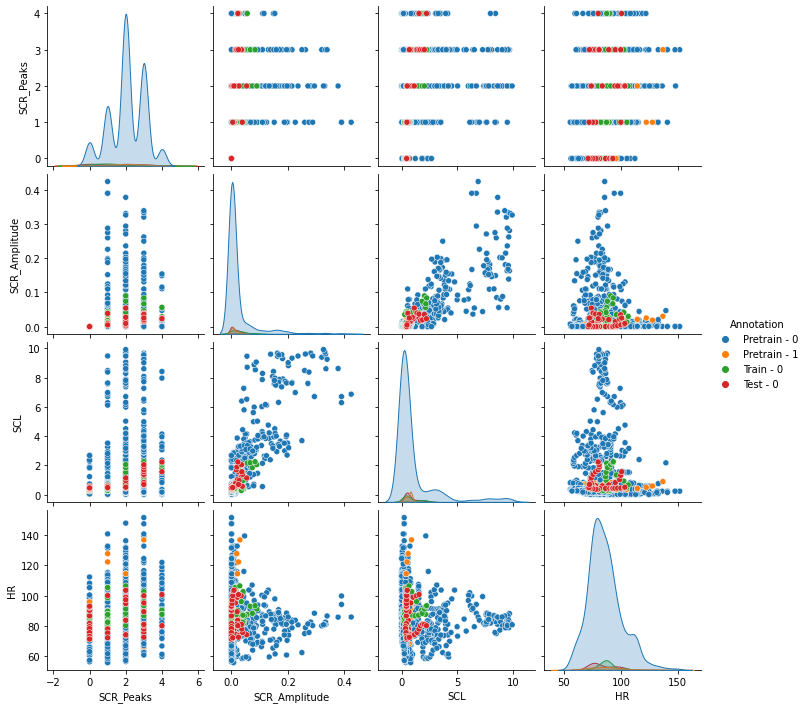

===Only participant===


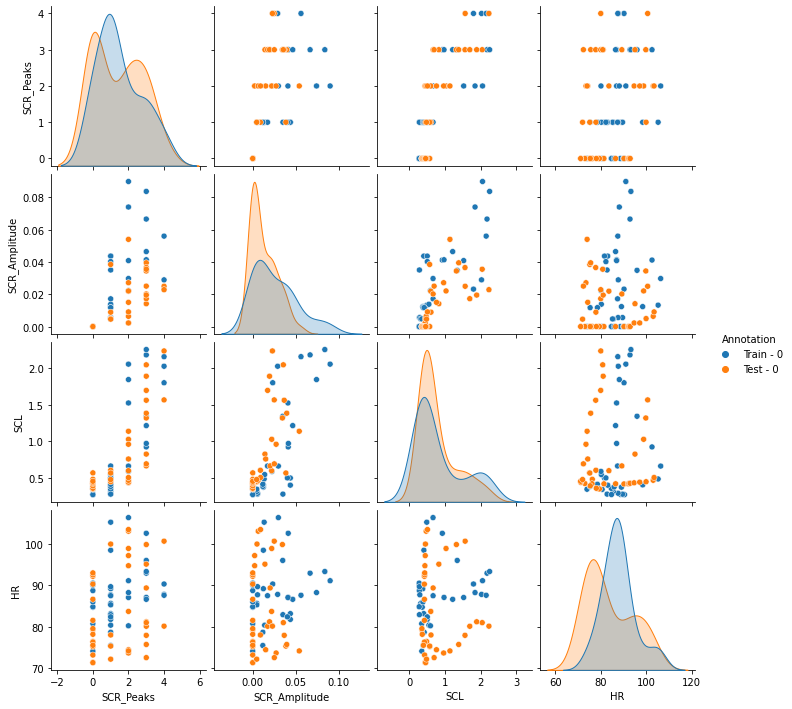

(1149, 5)
(45, 5)
(35, 5)
===All combined===


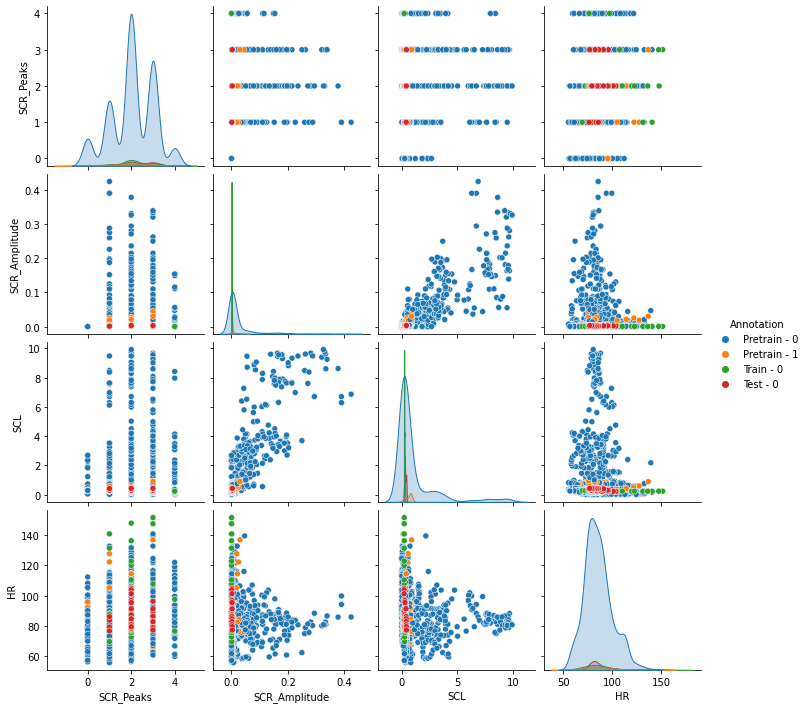

===Only participant===


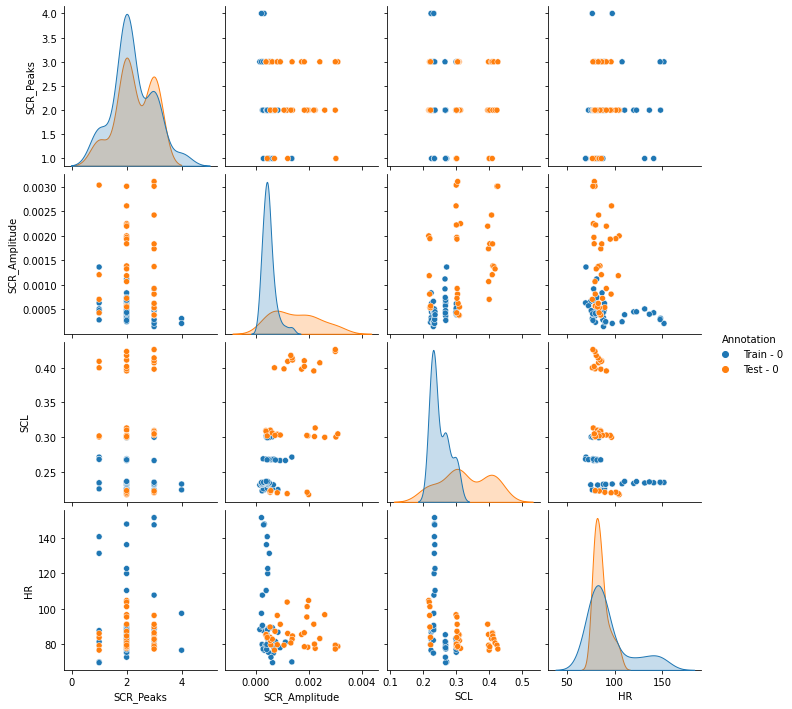

(1129, 5)
(65, 5)
(64, 5)
===All combined===


/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


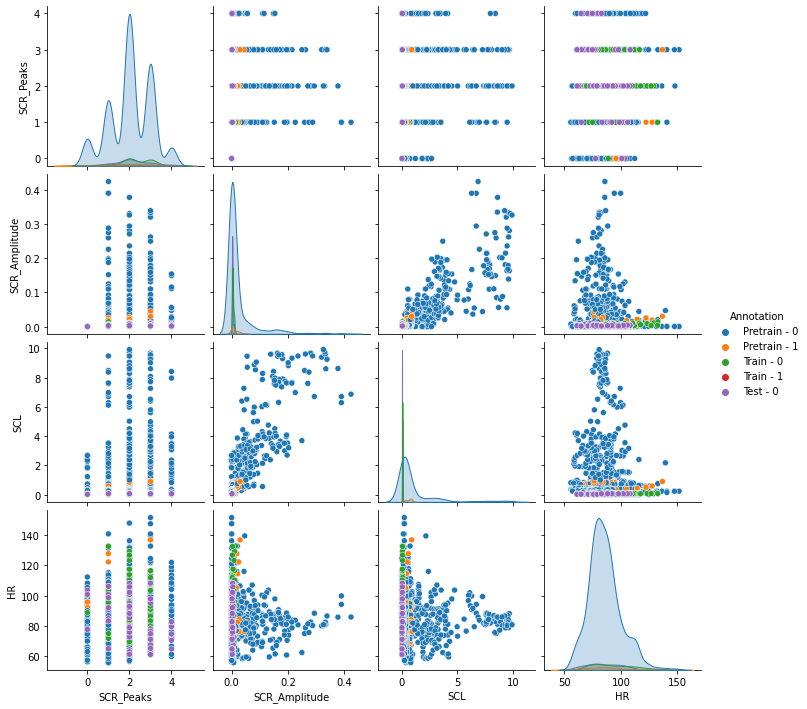

===Only participant===


/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


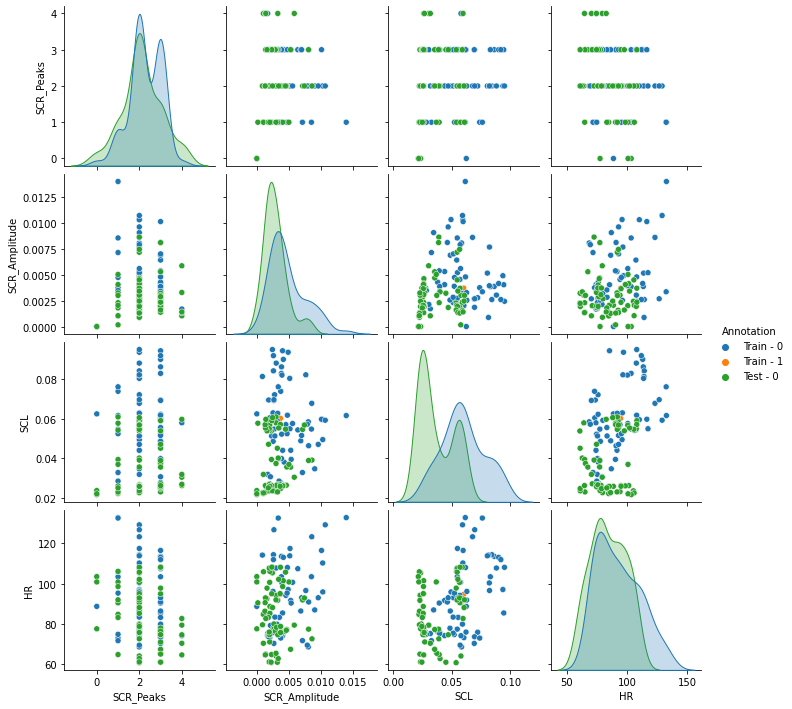

(1158, 5)
(36, 5)
(31, 5)
===All combined===


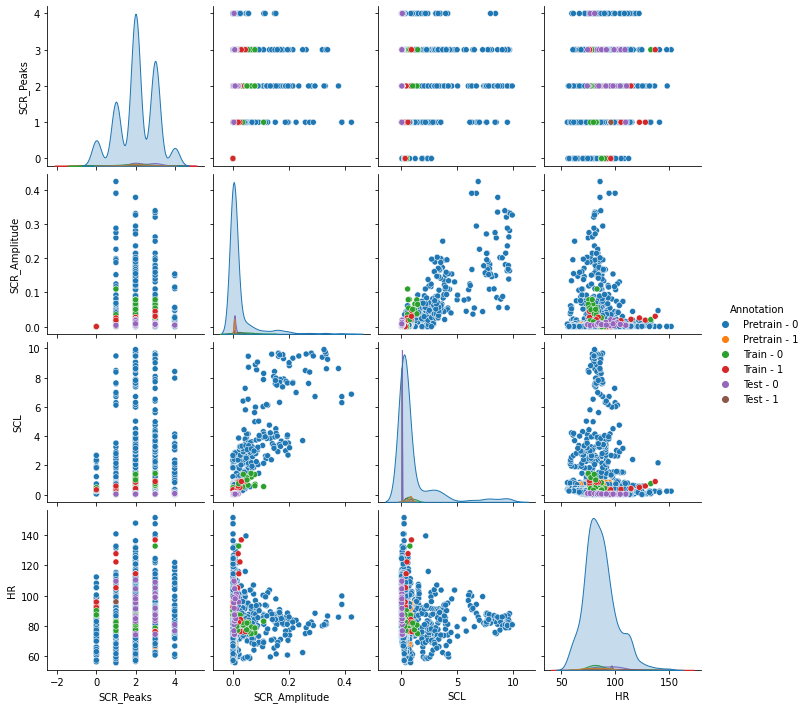

===Only participant===


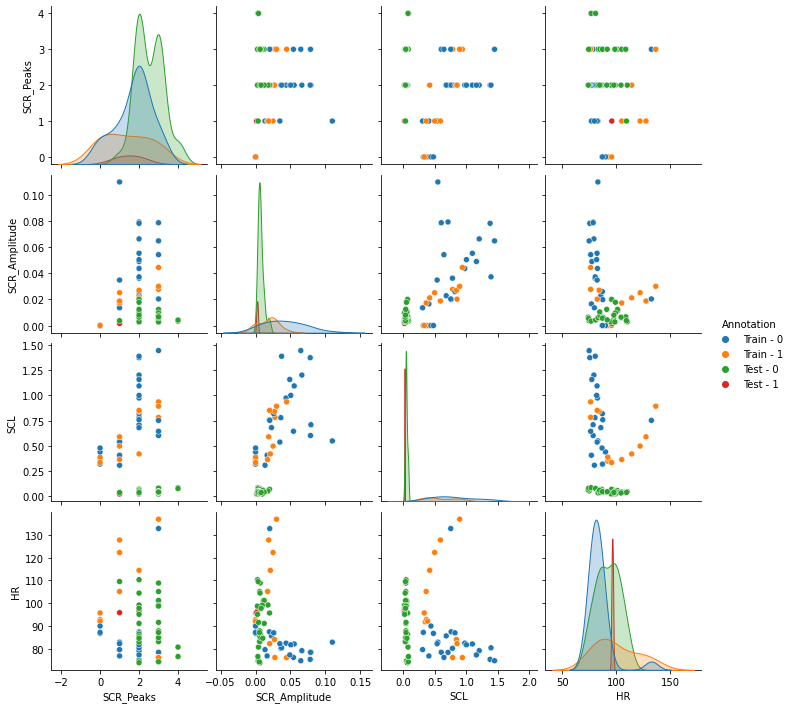

(1163, 5)
(31, 5)
(23, 5)
===All combined===


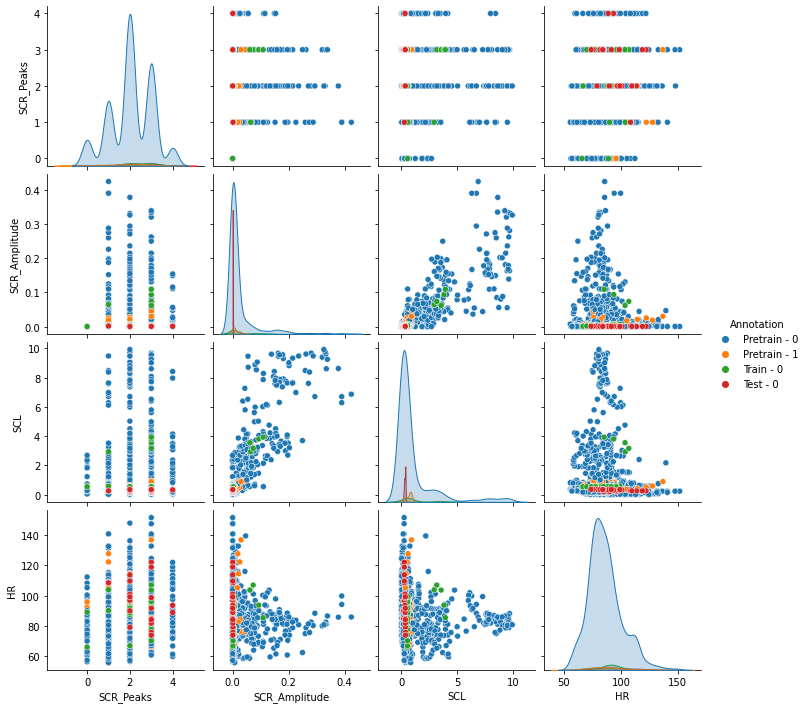

===Only participant===


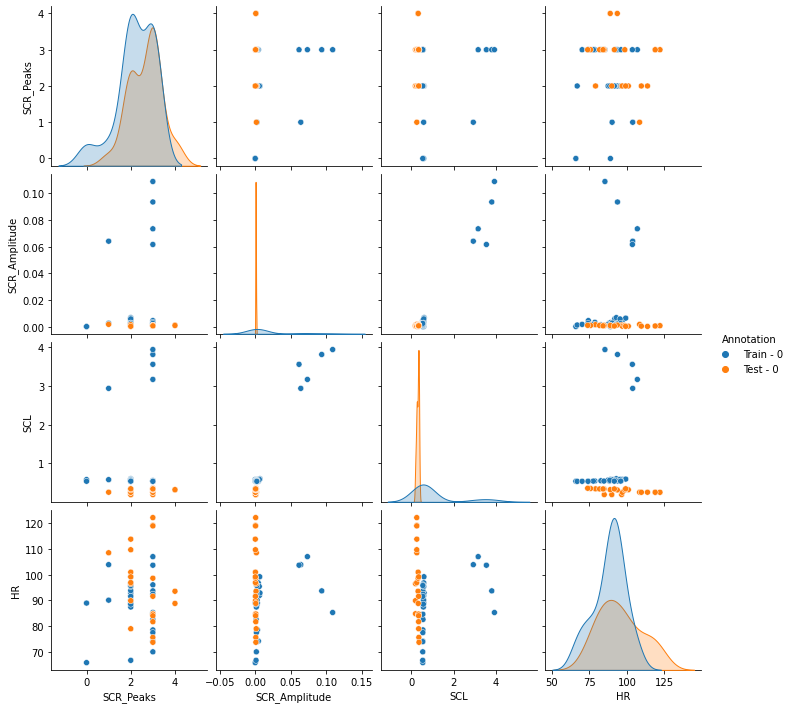

(1134, 5)
(60, 5)
(66, 5)
===All combined===


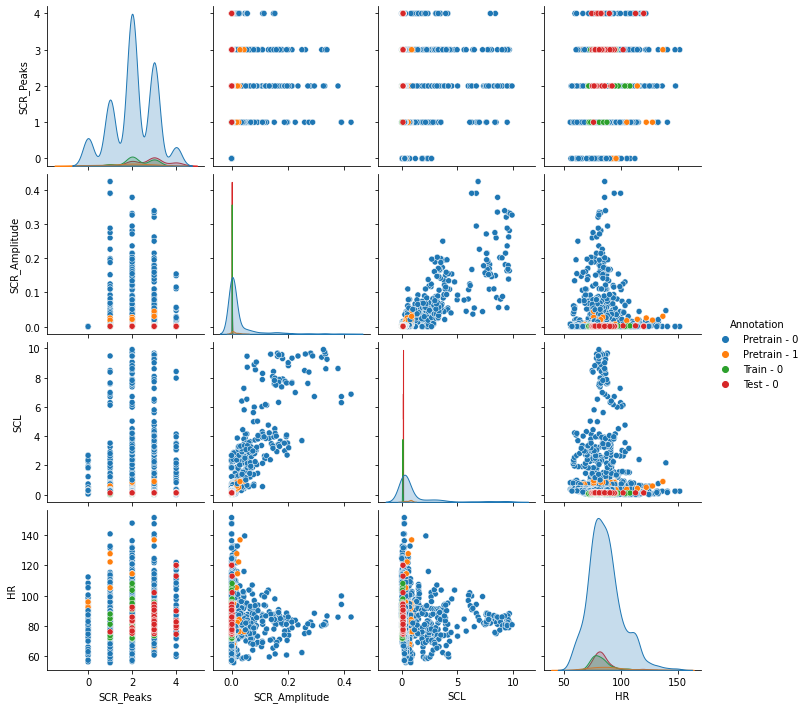

===Only participant===


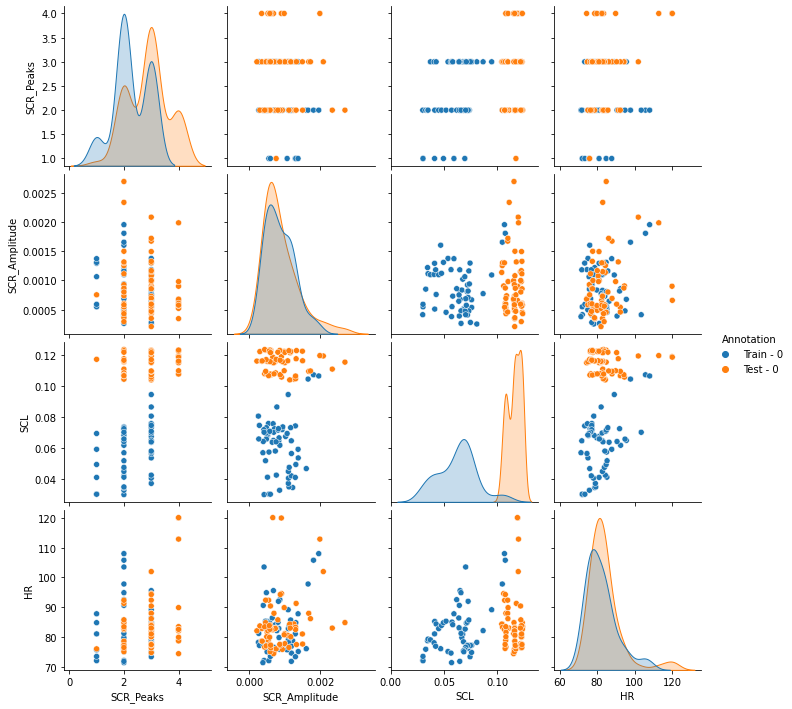

(1138, 5)
(56, 5)
(66, 5)
===All combined===


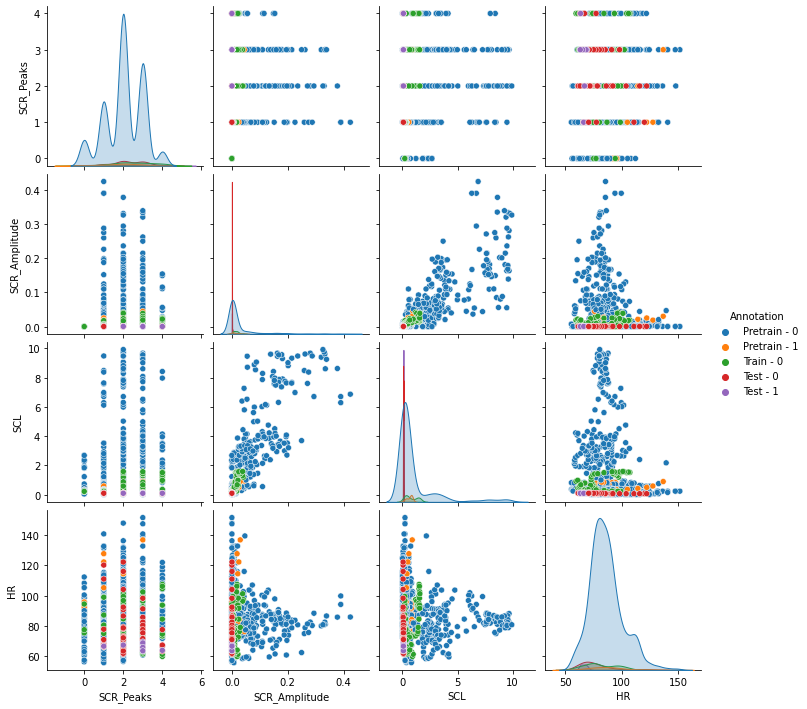

===Only participant===


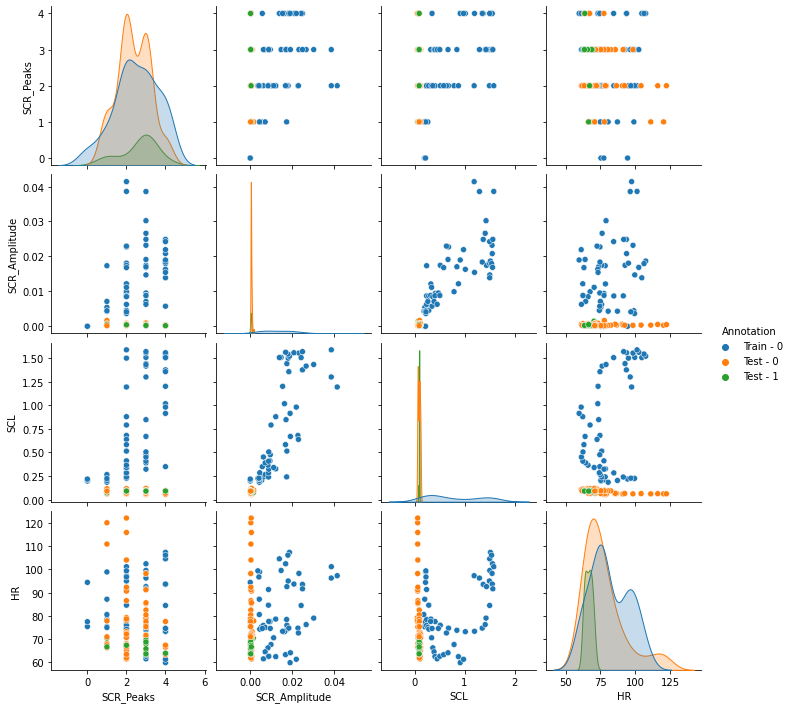

(1117, 5)
(77, 5)
(71, 5)
===All combined===


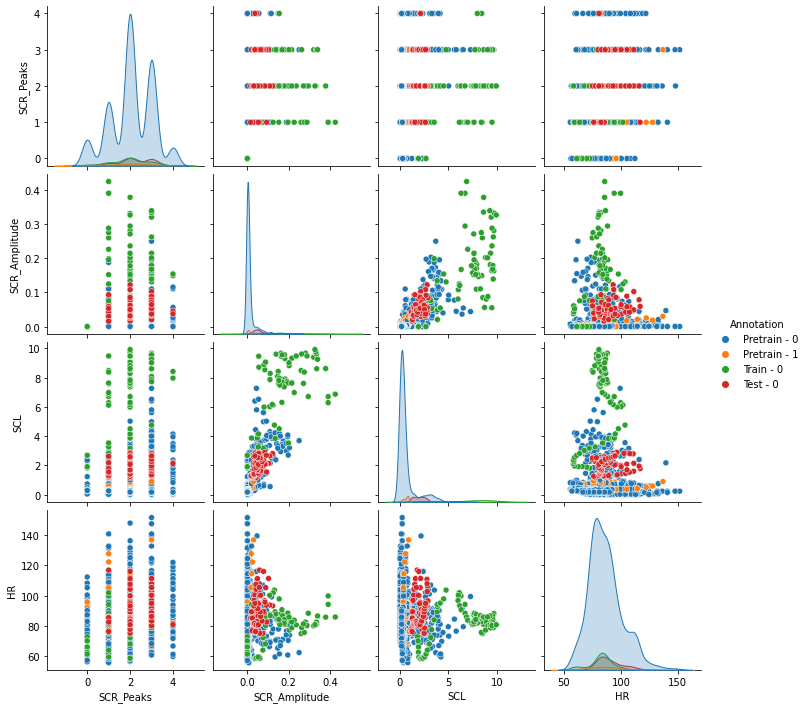

===Only participant===


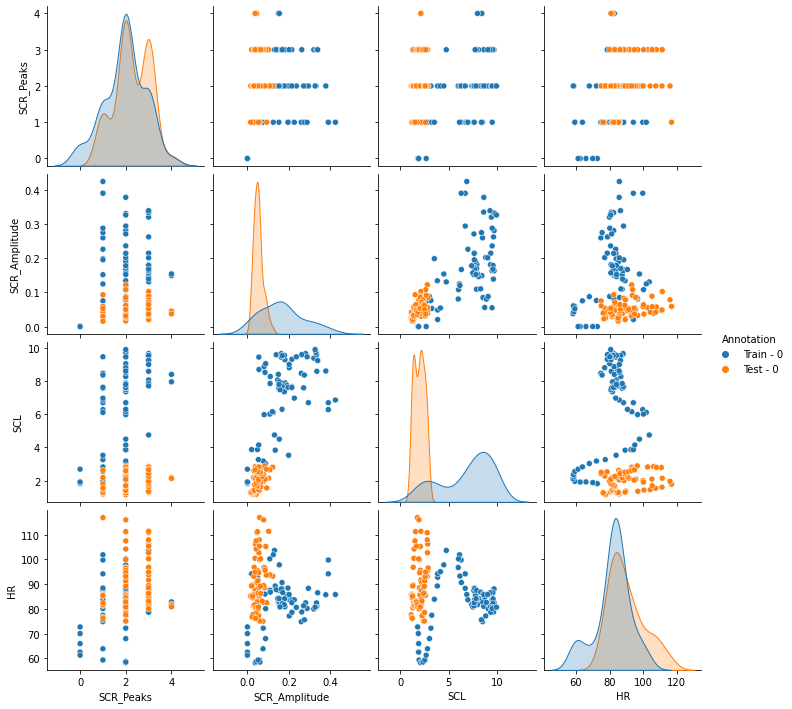

(1138, 5)
(56, 5)
(57, 5)
===All combined===


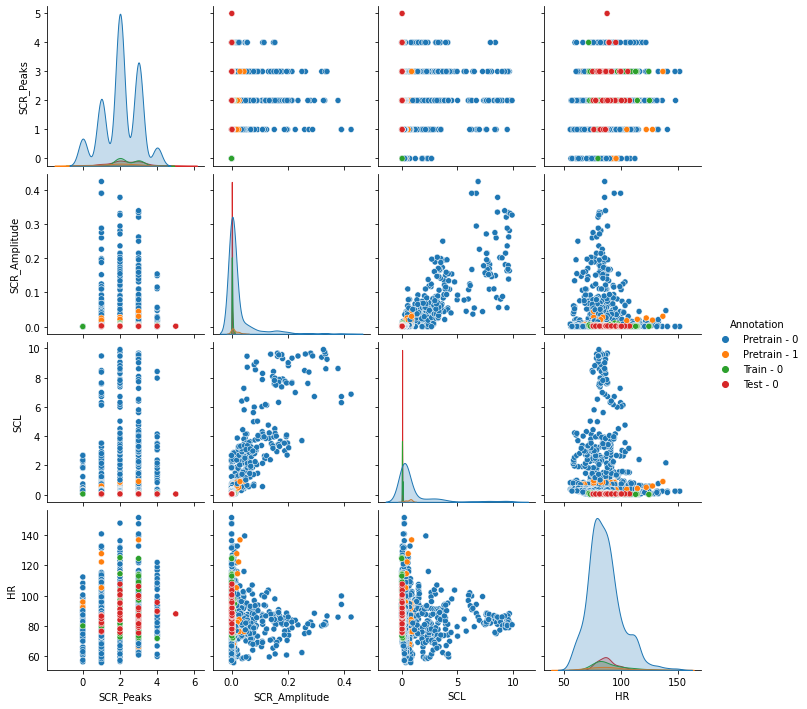

===Only participant===


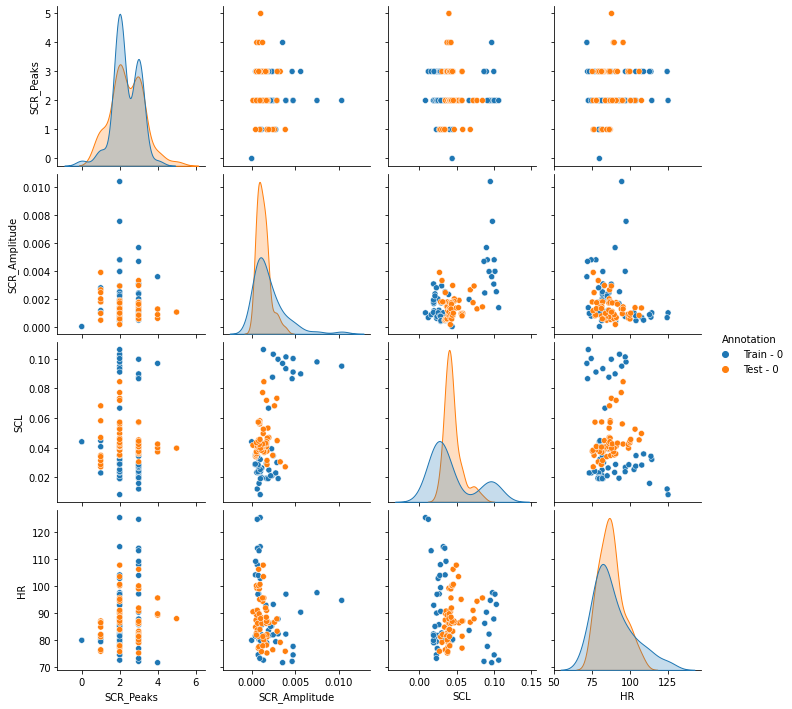

(1145, 5)
(49, 5)
(48, 5)
===All combined===


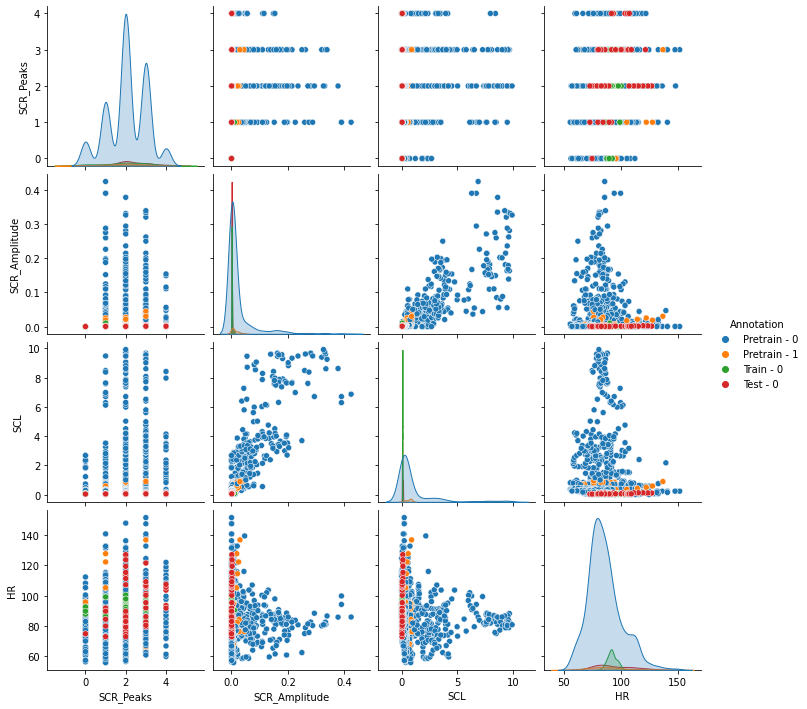

===Only participant===


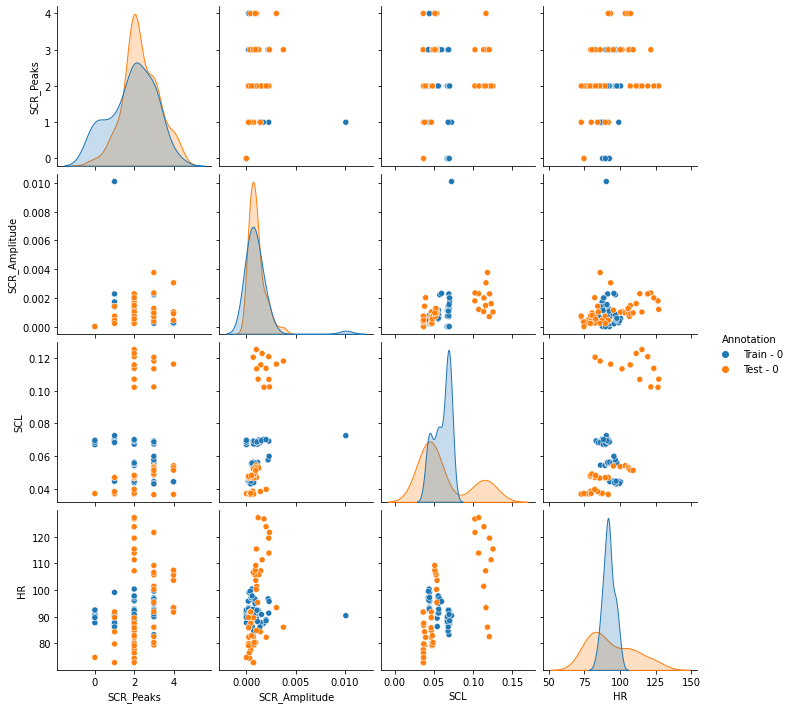

(1140, 5)
(54, 5)
(33, 5)
===All combined===


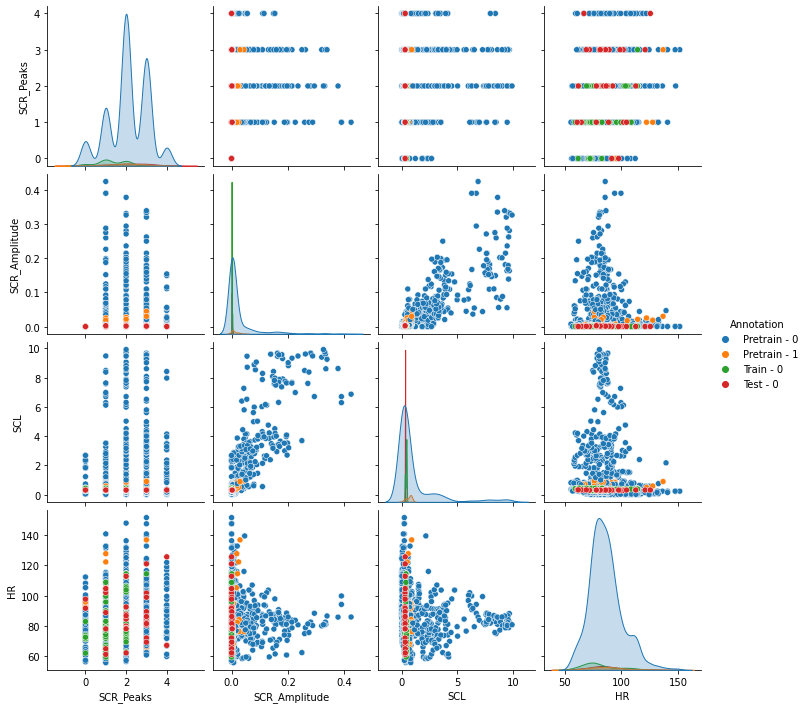

===Only participant===


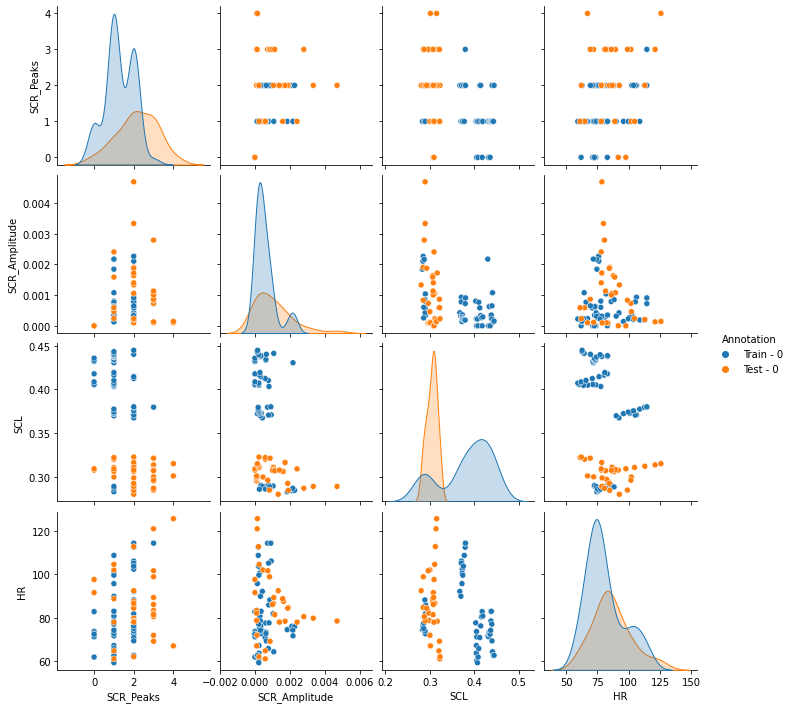

(1142, 5)
(52, 5)
(52, 5)
===All combined===


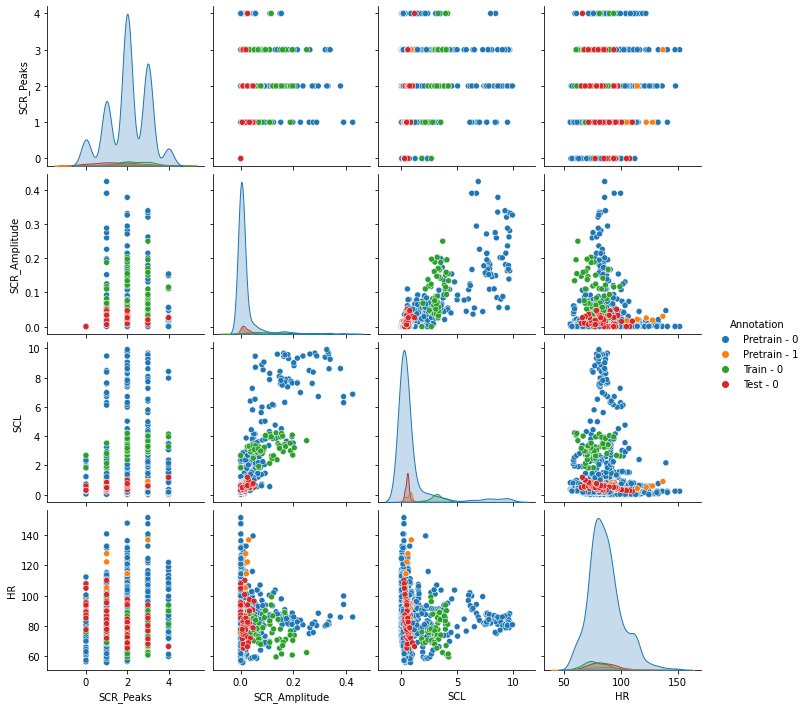

===Only participant===


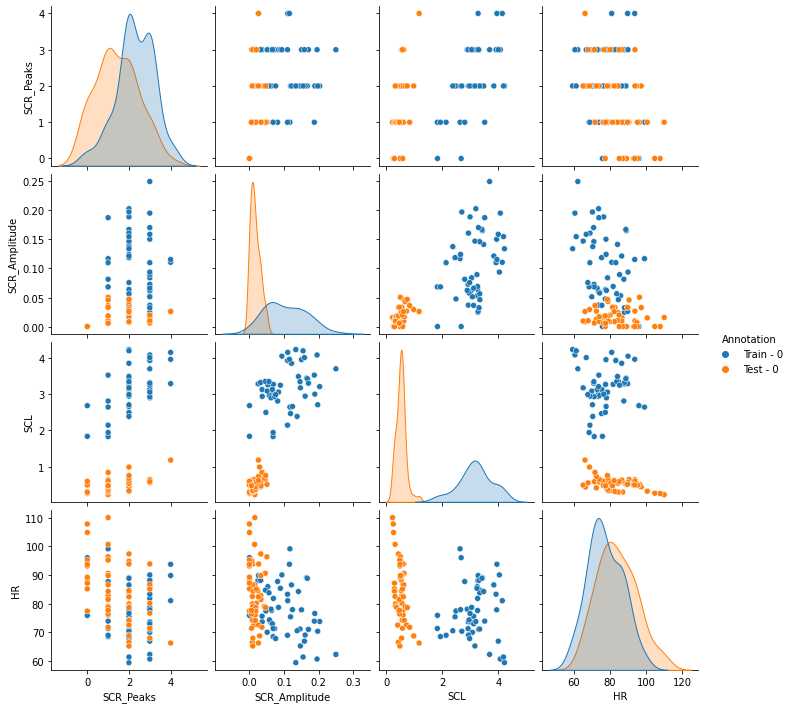

(1161, 5)
(33, 5)
(31, 5)
===All combined===


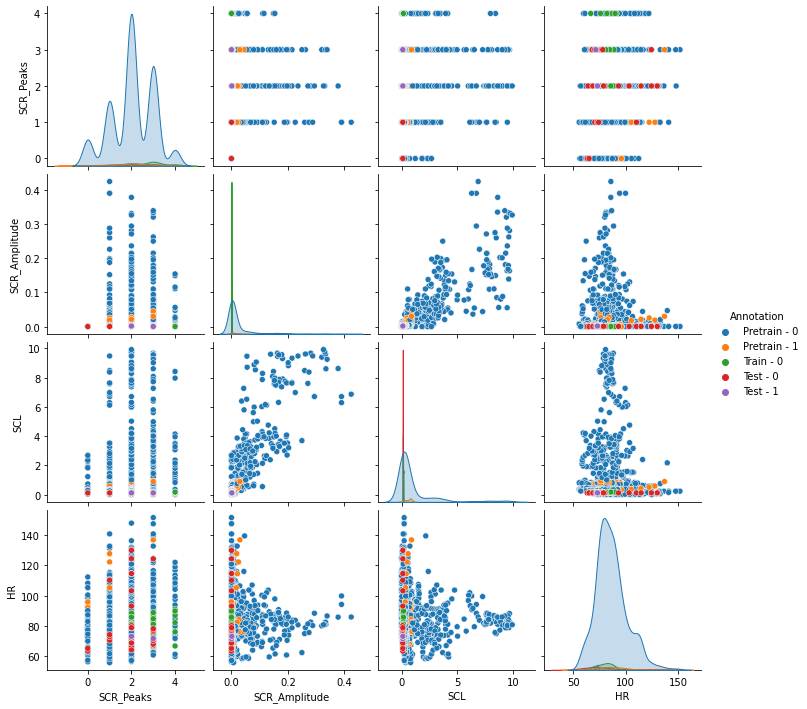

===Only participant===


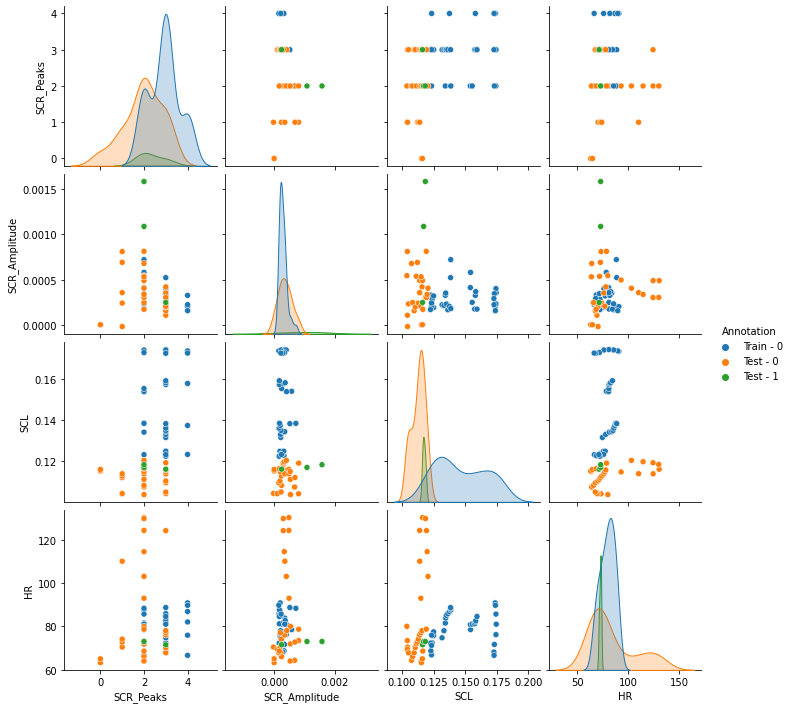

(1138, 5)
(56, 5)
(60, 5)
===All combined===


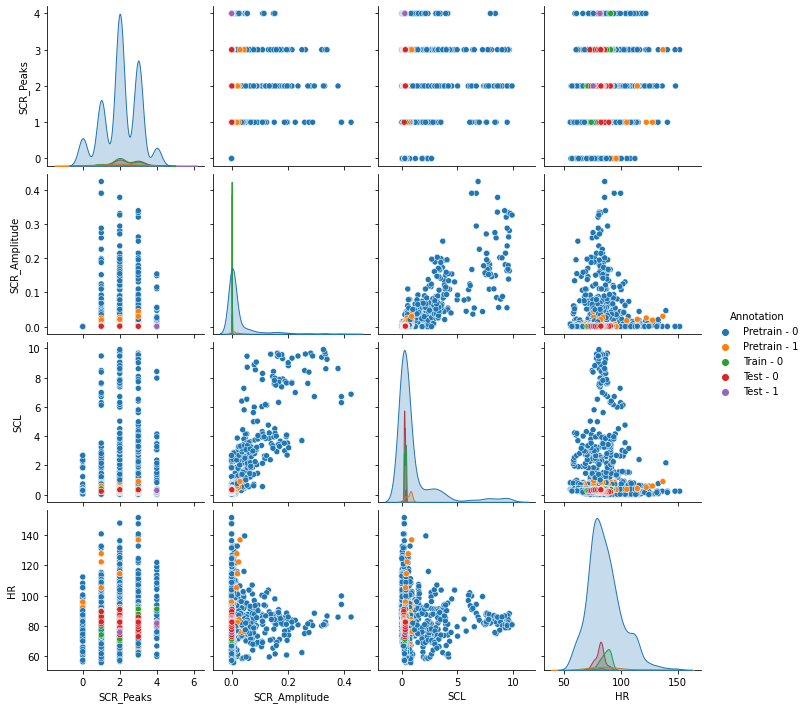

===Only participant===


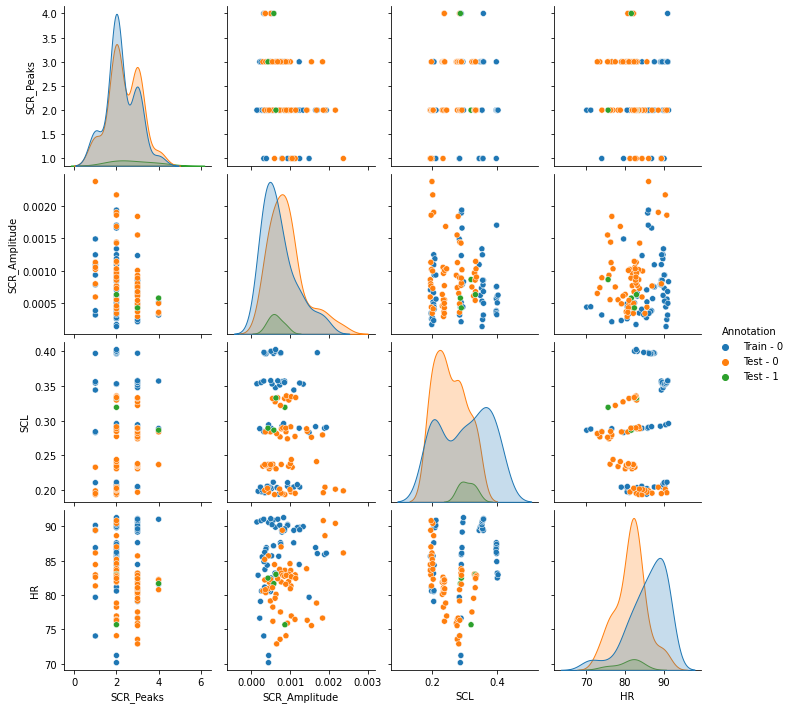

(1151, 5)
(43, 5)
(42, 5)
===All combined===


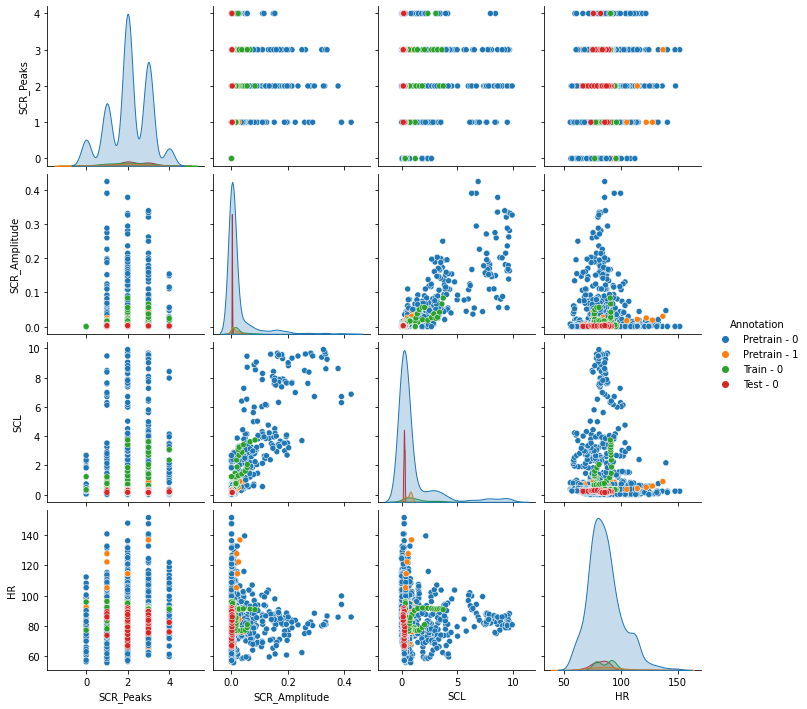

===Only participant===


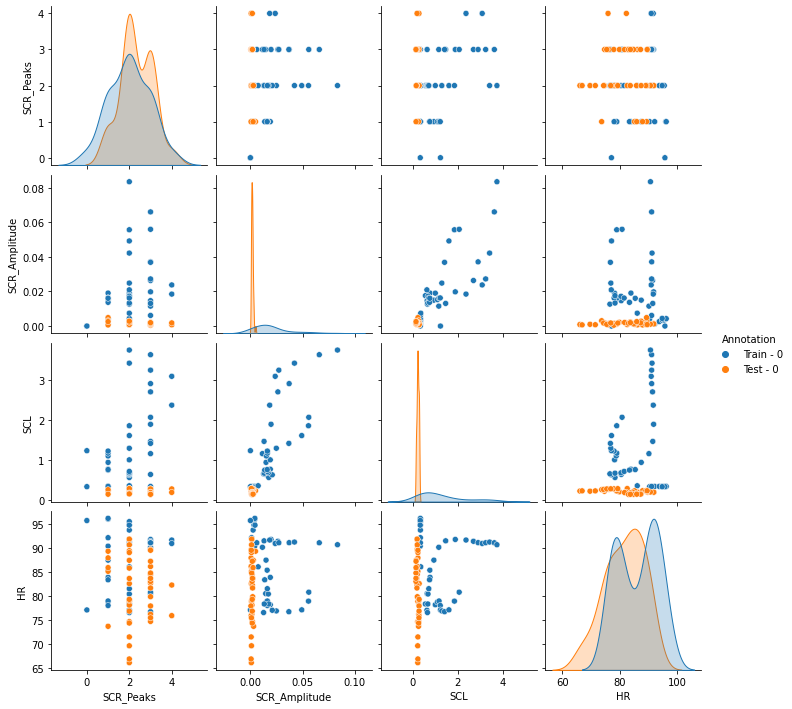

(1134, 5)
(60, 5)
(55, 5)
===All combined===


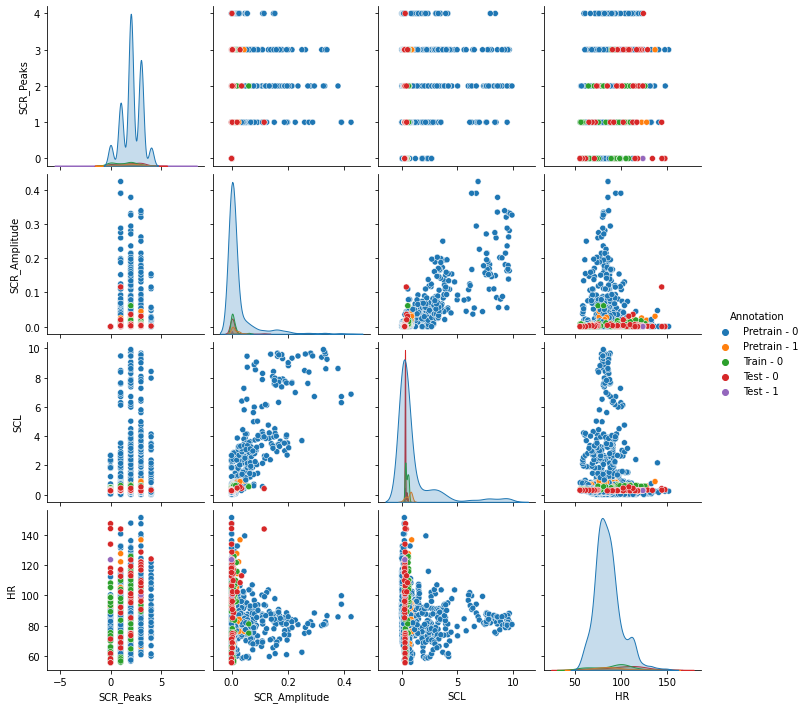

===Only participant===


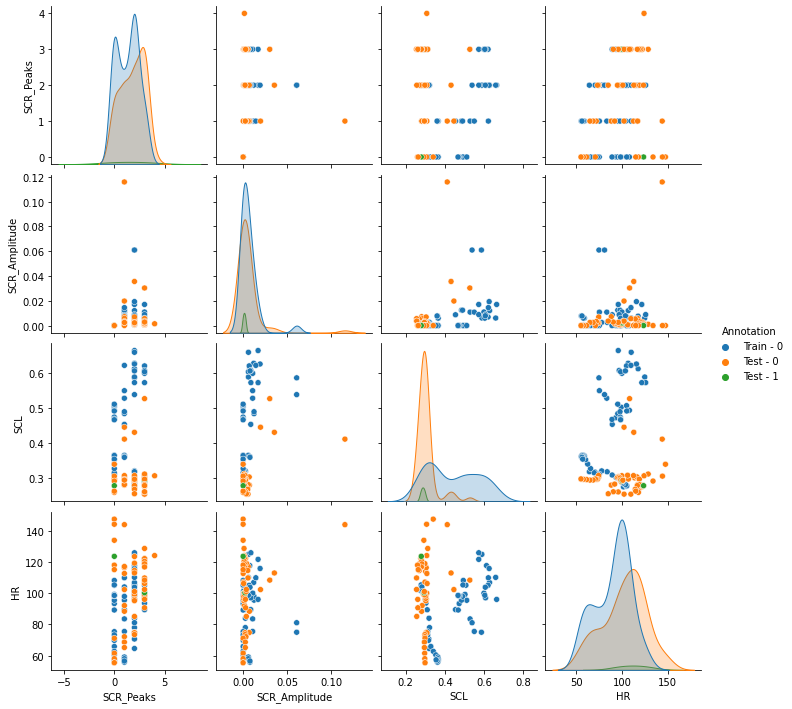

(1149, 5)
(45, 5)
(40, 5)
===All combined===


/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


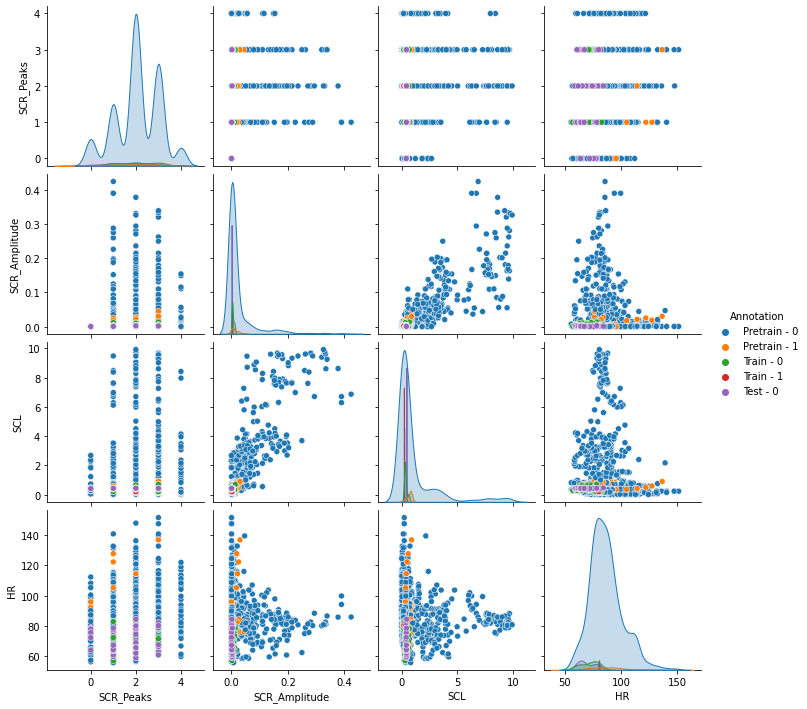

===Only participant===


/home/jason/.local/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


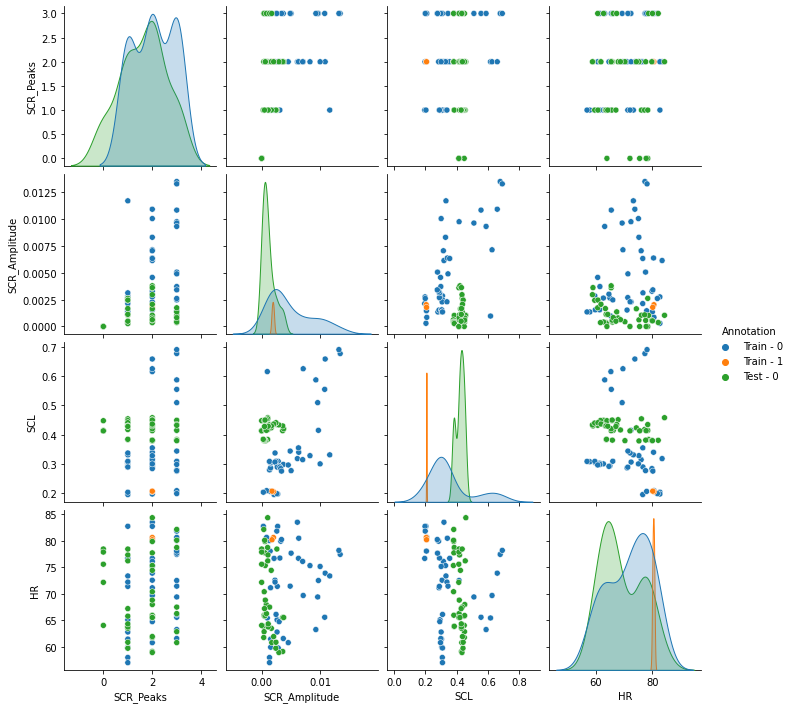

(1137, 5)
(57, 5)
(41, 5)
===All combined===


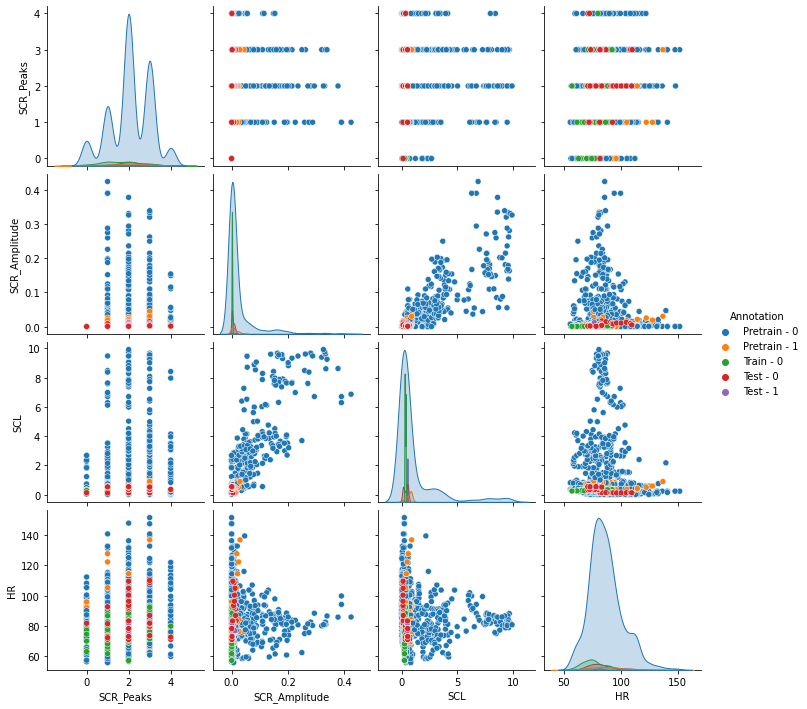

===Only participant===


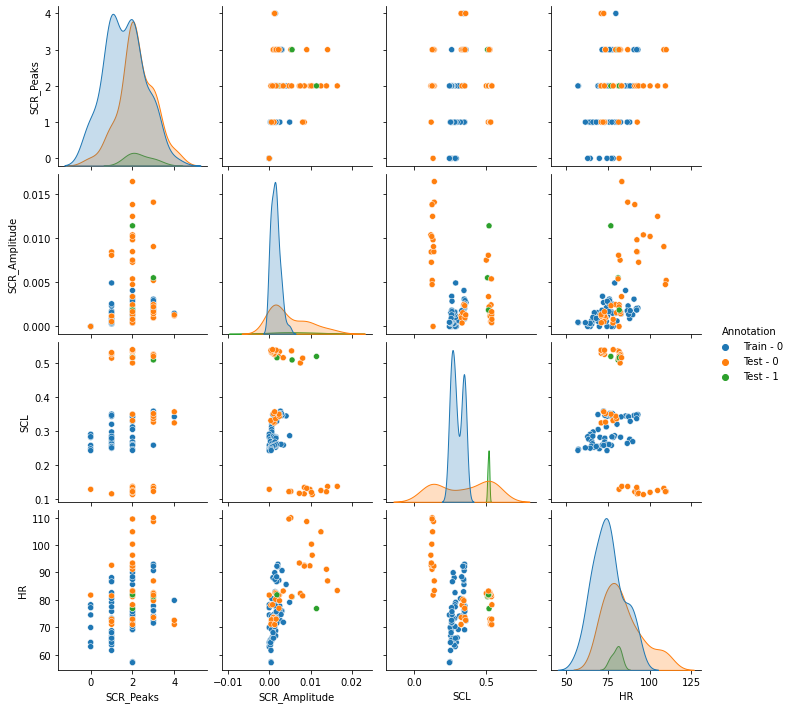

(1172, 5)
(22, 5)
(28, 5)
===All combined===


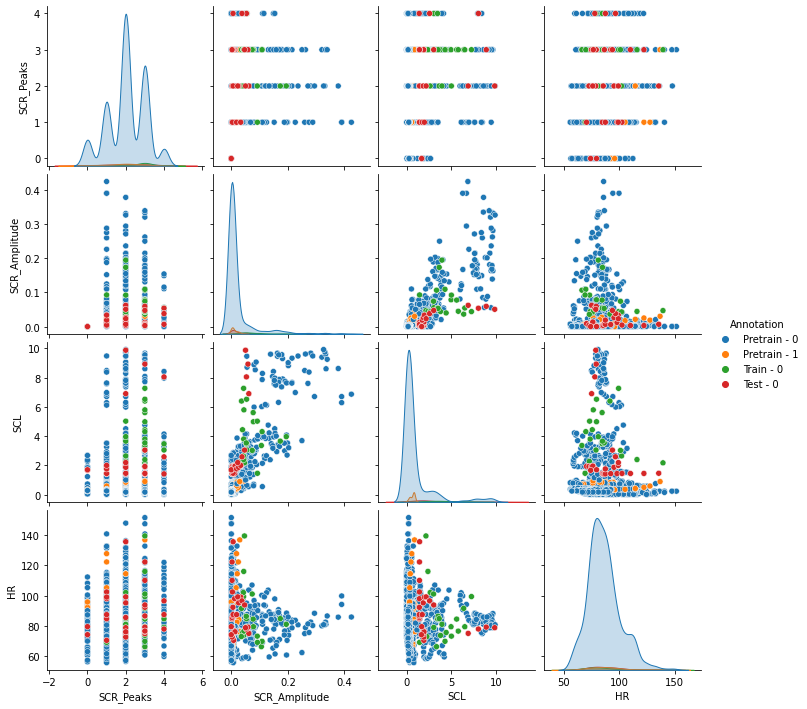

===Only participant===


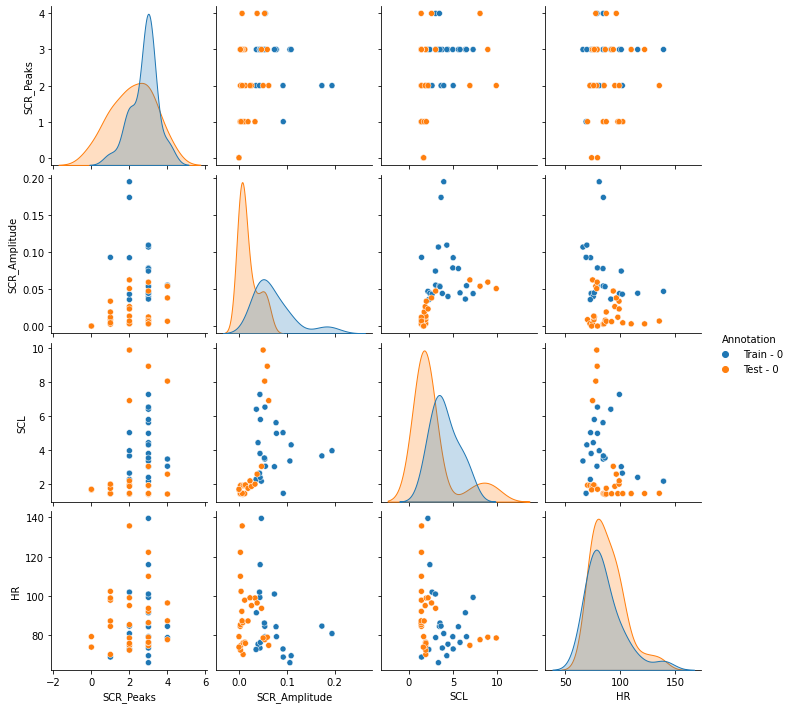

(1151, 5)
(43, 5)
(52, 5)
===All combined===


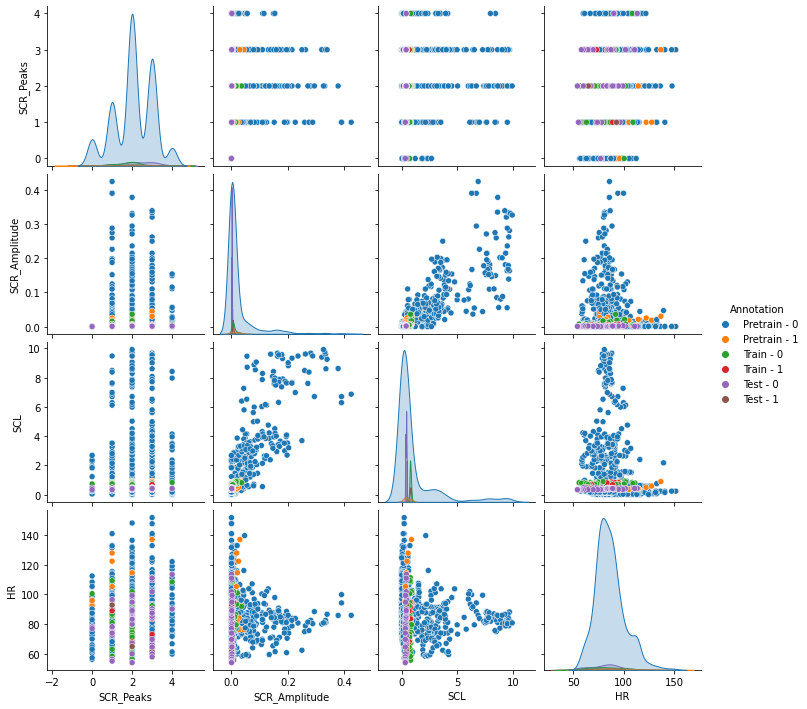

===Only participant===


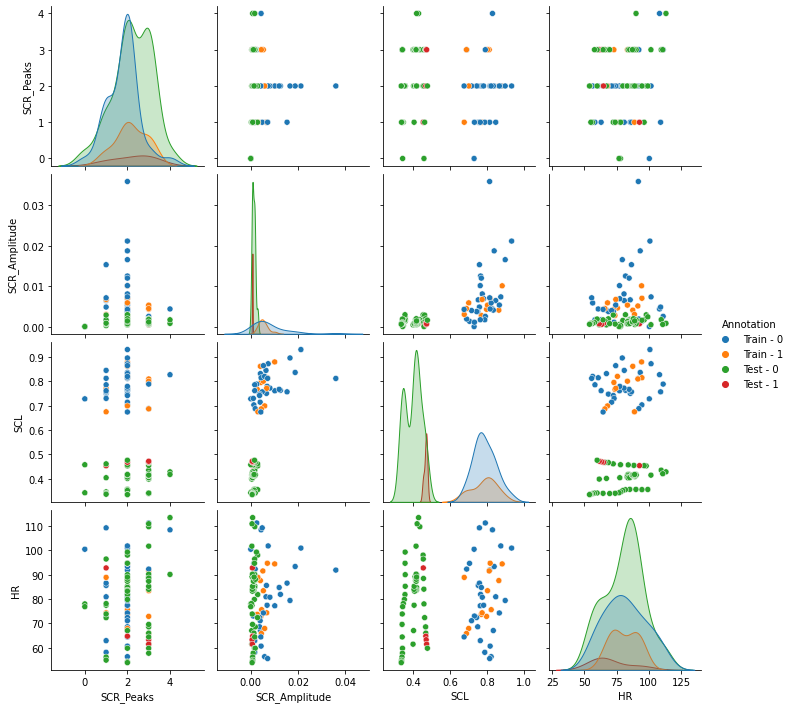

(1134, 5)
(60, 5)
(49, 5)
===All combined===


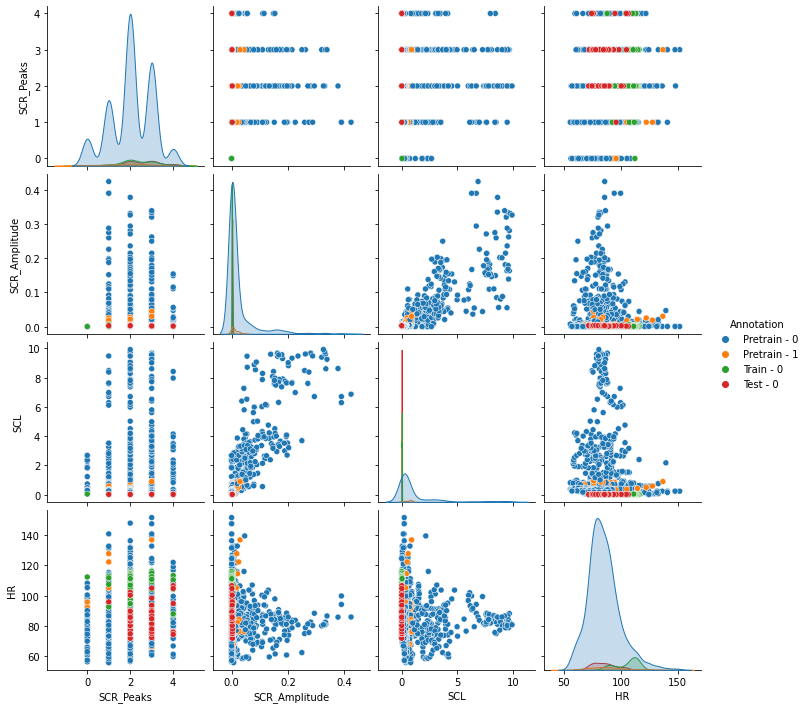

===Only participant===


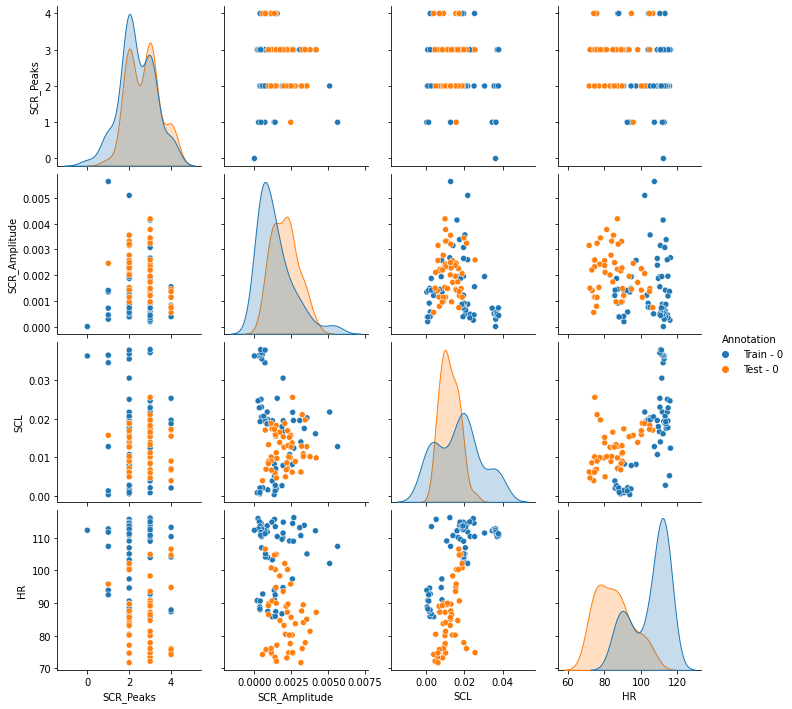

(1140, 5)
(54, 5)
(45, 5)
===All combined===


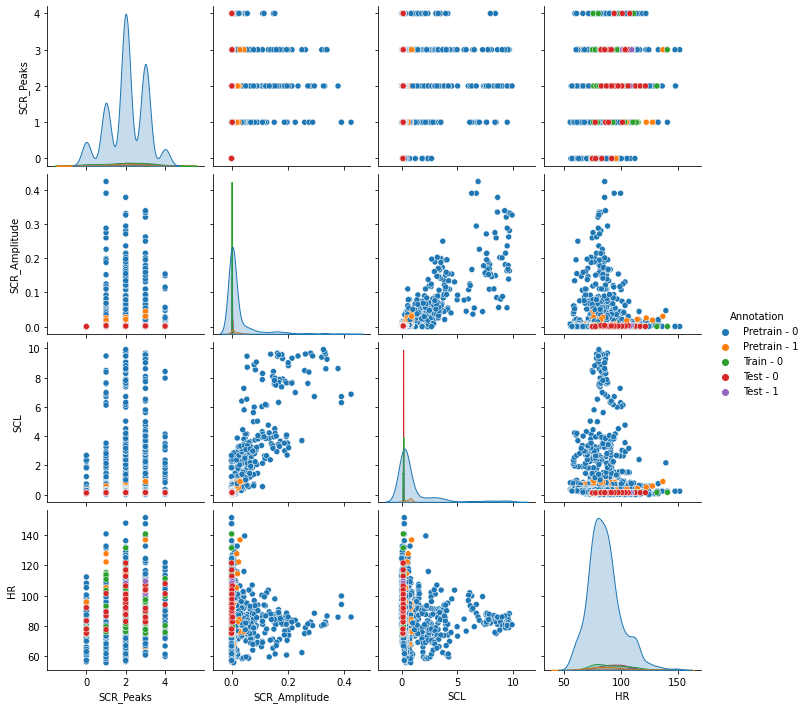

===Only participant===


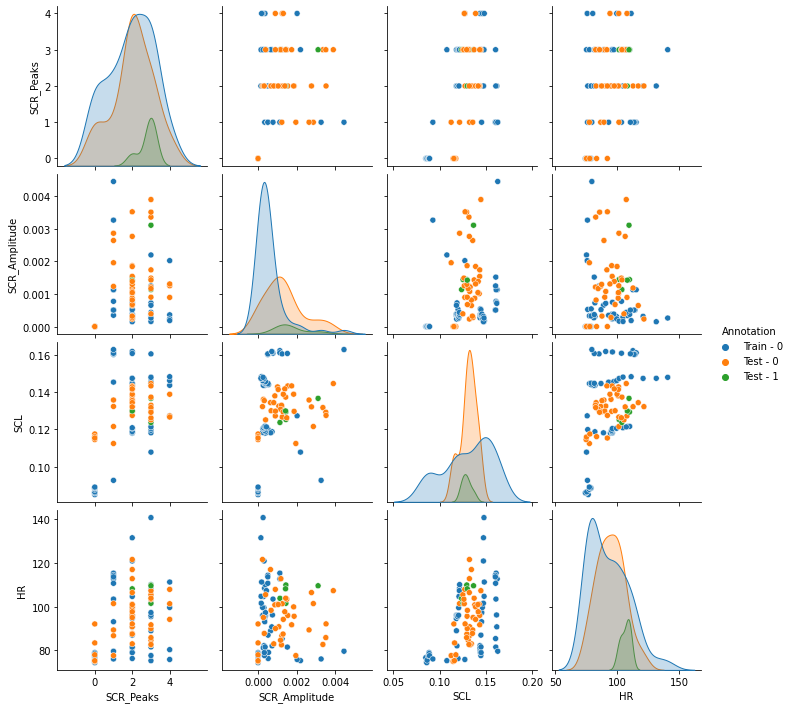

(1169, 5)
(25, 5)
(32, 5)
===All combined===


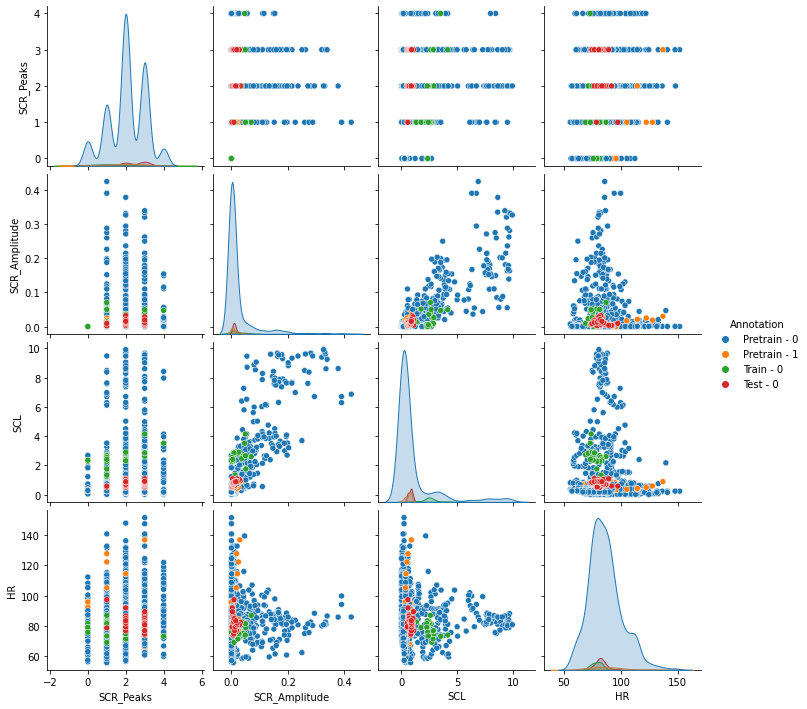

===Only participant===


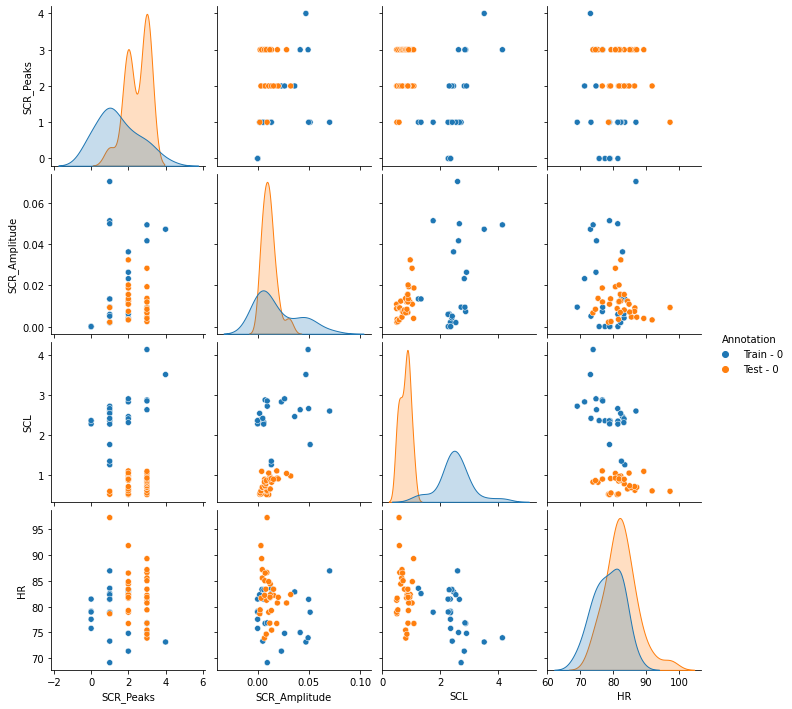

In [43]:
%matplotlib inline
for target_p in train_dict.keys():
    
    aux_participants = set(train_dict.keys())
    aux_participants.remove(target_p)
    
    pretrain = []
    
    for p in aux_participants:
        p_data = train_dict[p]
        pretrain.append(pd.concat(p_data, axis=0))
        
    pretrain = pd.concat(pretrain)
    
    p_data = train_dict[target_p]
    train = pd.concat(p_data, axis=0)
    
    p_data = test_dict[target_p]
    test = pd.concat(p_data, axis=0)
    
    print(pretrain.shape)
    print(train.shape)
    print(test.shape)
    
    pretrain['Annotation'] = 'Pretrain - ' + pretrain['Annotation'].astype(str)
    train['Annotation'] = 'Train - ' + train['Annotation'].astype(str)
    test['Annotation'] = 'Test - ' + test['Annotation'].astype(str)
    
    print('===All combined===')
    _ = sns.pairplot(pd.concat([pretrain, train, test], axis=0), hue='Annotation')
    plt.show()
    
    print('===Only participant===')
    _ = sns.pairplot(pd.concat([train, test], axis=0), hue='Annotation')
    plt.show()
        